<a href="https://colab.research.google.com/github/mithril-security/blindai/blob/jupyter-0.5.0-redux/examples/facenet/BlindAI-Facenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About this example

This example shows how you can run a Facenet model to perform Facial Recognition with confidentiality guarantees. 

By using BlindAI, people can send data for the AI to analyze their biometric data without having to fear privacy leaks.

Facenet is a state-of-the art ResNet model for Facial Recogntion. You can learn more about it on [Facenet repository](https://github.com/timesler/facenet-pytorch).

# Installing dependencies

Install the dependencies this example needs.

In [1]:
!pip install -q transformers[onnx] torch

     |████████████████████████████████| 4.7 MB 16.9 MB/s 
     |████████████████████████████████| 6.6 MB 50.7 MB/s 
     |████████████████████████████████| 120 kB 44.4 MB/s 
     |████████████████████████████████| 212 kB 46.3 MB/s 
     |████████████████████████████████| 83 kB 2.0 MB/s 
     |████████████████████████████████| 442 kB 51.7 MB/s 
     |████████████████████████████████| 4.9 MB 7.2 MB/s 
     |████████████████████████████████| 46 kB 1.4 MB/s 
     |████████████████████████████████| 55 kB 2.0 MB/s 
     |████████████████████████████████| 13.1 MB 46.2 MB/s 
     |████████████████████████████████| 99 kB 7.6 MB/s 
     |████████████████████████████████| 86 kB 5.3 MB/s 


Install the Facenet-pytorch library.

In [2]:
!pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 14.8 MB/s 


Install the latest version of BlindAI.

In [3]:
!pip install blindai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 11.3 MB/s 
     |████████████████████████████████| 2.4 MB 54.5 MB/s 
     |████████████████████████████████| 4.0 MB 45.2 MB/s 
     |████████████████████████████████| 4.6 MB 36.9 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.47.0
    Uninstalling grpcio-1.47.0:
      Successfully uninstalled grpcio-1.47.0


# Preparing the model

The first step here is to prepare the model to perform facial recognition. 

To make it simpler, we will do an example where we will hardcode the database of biometric templates in the neural network itself. This works if the database of people to identify is fixed. For more dynamic workload, BlindAI can be adapted to suit this use case but we will not cover it here

First we load the pretrained Facenet model.

In [4]:
from facenet_pytorch import InceptionResnetV1
import torch

resnet = InceptionResnetV1(pretrained='vggface2').eval()

  0%|          | 0.00/107M [00:00<?, ?B/s]

We then download the people that will serve as our biometric database. The goal here is to use a neural network to see if a new person to be identified belongs to one of the three people registered.

In [5]:
!wget https://raw.githubusercontent.com/mithril-security/blindai/master/examples/facenet/woman_0.jpg
!wget https://raw.githubusercontent.com/mithril-security/blindai/master/examples/facenet/woman_1.jpg
!wget https://raw.githubusercontent.com/mithril-security/blindai/master/examples/facenet/woman_2.jpg

--2022-09-11 19:35:43--  https://raw.githubusercontent.com/mithril-security/blindai/master/examples/facenet/woman_0.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4853 (4.7K) [image/jpeg]
Saving to: ‘woman_0.jpg’

woman_0.jpg         100%[===================>]   4.74K  --.-KB/s    in 0s      

2022-09-11 19:35:43 (35.1 MB/s) - ‘woman_0.jpg’ saved [4853/4853]

--2022-09-11 19:35:44--  https://raw.githubusercontent.com/mithril-security/blindai/master/examples/facenet/woman_1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4

We can have a look at our dataset. 

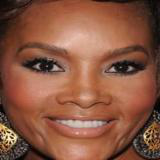

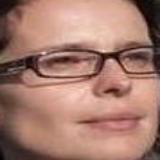

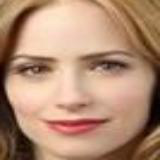

In [6]:
from PIL import Image
from IPython.display import display

files = [f"woman_{i}.jpg" for i in range(3)]

display(Image.open(files[0]), Image.open(files[1]), Image.open(files[2]))

Here we will do the enrollment phase, i.e. extract a template from each person, and store it. Those templates will be used as references to compute a similarity score when someone new comes in to be identified.

In [7]:
import numpy as np

embeddings = []

for file in files:
    # We open each file and preprocess it
    im = Image.open(file)
    im = torch.tensor(np.asarray(im)).permute(2,0,1).unsqueeze(0) / 128.0 - 1
    
    # We make the tensor go through the ResNet to extract a template
    embedding = resnet(im)
    embeddings.append(embedding.squeeze(0))
    
# We stack everything in a matrix
embeddings = torch.stack(embeddings)

Because the scoring will be done through a dot product of a new candidate template with the registered templates, we can implement this scoring as a matrix multiplication between the registered tempalte and the new template:

In [8]:
import torch.nn as nn

# Create the scoring layer with a matrix multiplication
scoring_layer = nn.Linear(512, 3, bias=False)

# Store the computed embeddings inside
scoring_layer.weight.data = embeddings

full_network = nn.Sequential(
    resnet,
    scoring_layer
)

Before sending our model to BlindAI, we will how it performs in practice.

Let's download a test set, containing a different picture of the second woman we registered.

In [9]:
!wget https://raw.githubusercontent.com/mithril-security/blindai/master/examples/facenet/woman_test.jpg

--2022-09-11 19:35:45--  https://raw.githubusercontent.com/mithril-security/blindai/master/examples/facenet/woman_test.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3856 (3.8K) [image/jpeg]
Saving to: ‘woman_test.jpg’

woman_test.jpg      100%[===================>]   3.77K  --.-KB/s    in 0s      

2022-09-11 19:35:45 (43.3 MB/s) - ‘woman_test.jpg’ saved [3856/3856]



We can see below that the two pictures are indeed from the same person.

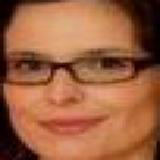

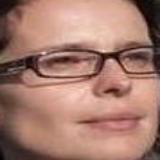

In [10]:
test_im = Image.open("woman_test.jpg")
display(test_im, Image.open("woman_1.jpg"))

We can now apply our full network, which will extract a template from the test image, and compute a dot product between the new templates and the registered templates.

In [11]:
test_im = torch.tensor(np.asarray(test_im)).permute(2,0,1).unsqueeze(0) / 128.0 - 1

scores = full_network(test_im)

We can see that the scores reflect the truth: the dot product of the embeddings of the test image with the first and third women are low, while the score is high with the second woman. This makes sense, as the neural network was trained to provide a high score for pictures of the same person, and make the score low for different people.

In [12]:
scores

tensor([[-0.0405,  0.7394,  0.0676]], grad_fn=<MmBackward0>)

Now we can export the model to be fed to BlindAI to deploy it with privacy guarantees.

In [13]:
torch.onnx.export(full_network,               # model being run
                  test_im,                         # model input (or a tuple for multiple inputs)
                  "facenet.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
)

# Deployment on BlindAI

Now we can upload the model to BlindAI Cloud. To upload of the model, make sure you have an API key.

You can get one on the [Mithril Cloud](https://cloud.mithrilsecurity.io/).

You might get an error if the name you want to use is already taken, as models are uniquely identified by their `model_id`. We will implement namespace soon to avoid that. Meanwhile, you will have to choose a unique ID. We provide an example below to upload your model with a unique name:

In [14]:
import blindai
import uuid

api_key = "YOUR_API_KEY" # Enter your API key here
model_id = "facenet-" + str(uuid.uuid4())

# Upload the ONNX file to the remote enclave
with blindai.Connection(api_key=api_key) as client:
    response = client.upload_model("facenet.onnx", model_id=model_id)

This securely uploads the model to the Mithril Cloud.
If you wish to run this example on premise, you should read the [Deploy on Hardware](https://blindai.mithrilsecurity.io/en/latest/getting-started/deploy-on-hardware/) documentation page.

# Sending data for confidential prediction

Now it's time to check it's working live!

We will just prepare some input for the model inside the secure enclave of BlindAI to process it.

First we prepare our input data, the test image we used before.

In [15]:
from PIL import Image
import torch

test_im = Image.open("woman_test.jpg")
test_im = torch.tensor(np.asarray(test_im)).permute(2,0,1).unsqueeze(0) / 128.0 - 1

Now we can send the biometric data to be processed confidentially!

In [16]:
with blindai.Connection() as client:
  response = client.predict(model_id, test_im)

As we can see below, the results are quite similar from the regular inference.

In [17]:
response.output[0].as_flat()

[-0.04054301232099533, 0.7393513321876526, 0.06757991760969162]

Et voila! We have been able to apply a start of the art model for facial recognition, without ever having to show the data in clear to the people operating the service!

If you have liked this example, do not hesitate to drop a star on our [GitHub](https://github.com/mithril-security/blindai) and chat with us on our [Discord](https://discord.gg/TxEHagpWd4)!